# Prompt evaluation notebook

In [8]:
import os
from kaggle import api 
from dotenv import load_dotenv
import numpy as np
from app.pipelines.workflow import setup_preloaded_chroma, setup_preloaded_RAG
from app.modules.qa_chain_composer.utils import create_multi_modal_query

from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain.chains import RetrievalQA

import random
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser

from datasets import Dataset
from pydantic import BaseModel, Field
from tqdm import tqdm

In [3]:
load_dotenv()
os.environ['ROOT_DIR'] = "./"

### Loading saved datasets from kaggle

In [5]:
if not os.path.exists("./data/doc_dataset"):
    api.dataset_download_files('ivanhusarov/the-batch-articles-initial', path='./data/doc_dataset', unzip=True)
if not os.path.exists("./data/image_descriptions_dataset"):
    api.dataset_download_files('ivanhusarov/the-batch-articles-image-descriptions', path='./data/image_descriptions_dataset', unzip=True)
if not os.path.exists("./chroma_preloaded"):
    api.dataset_download_files('ivanhusarov/the-batch-rag-chroma', path='chroma_preloaded', unzip=True)

### Setting up retriever

In [4]:
vector_store = setup_preloaded_chroma()

In [31]:
llm = ChatOpenAI(model='gpt-4o', temperature=0)

retriever = vector_store.as_retriever(search_kwargs={"k": 10})

compressor = CohereRerank(model="rerank-english-v3.0")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

### Setting up template for synthetic dataset generation

In [46]:
# Define the schema for output
class QAFormat(BaseModel):
    question: str = Field(default=None, description="Generated question about the context")
    answer: str = Field(default=None, description="Generated answer on question from the context")

qa_template = """\
You are a University Professor creating a test for advanced students. Create a question that is specific to the context. Avoid creating generic or general questions. Don't say I don't know.
Consider the following context: {context}


Return your response as a JSON object with the following structure:
{{
    "question": a question about the context.
    "answer": an answer from the context.
}}

Always return your response as a JSON object.
"""

full_doc_list = vector_store.get()["documents"]
context = full_doc_list[0]

parser = JsonOutputParser(pydantic_object=QAFormat)

prompt = PromptTemplate(
    template=qa_template,
    input_variables=["context"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

chain = prompt | llm | parser

{'question': 'What was the surprising outcome of the auction for the painting created by the AI-powered robot Ai-Da?',
 'answer': 'A painting of mathematician Alan Turing created by the AI-powered robot Ai-Da sold at Sotheby’s for $1.1 million, far exceeding initial estimates.'}

### Picking random documents to generate synthetic qa-pairs on

In [52]:
from random import sample

random.seed(42)

full_doc_list = vector_store.get()["documents"]
processed_sample = sample(full_doc_list, 20)

synthetic_questions = []
synthetic_ground_truths = []
contexts = []

for sample_entry in processed_sample:
    result = chain.invoke({"context": sample_entry})
    synthetic_ground_truths.append(result["answer"])
    synthetic_questions.append(result["question"])
    contexts.append(sample_entry)

questions = synthetic_questions
ground_truths = synthetic_ground_truths
data = {
    "question": questions,
    "contexts": contexts,
    "ground_truth": ground_truths
}

dataset = Dataset.from_dict(data)

In [53]:
# Sample item from dataset
dataset[3]

{'question': 'What is the key advancement in the new architecture that allows it to outperform a fully trained AlexNet model with only a few labeled samples?',
 'contexts': 'The power of deep learning is blunted in domains where labeled training data is scarce.But that may be changing, thanks to a new architecture that recognizes images with high accuracy based on few labeled samples.What’s new: Researchers devised a network that, given a small number of labeled images, can learn enough from unlabeled images to outperform a fully trained AlexNet model.',
 'ground_truth': 'The new architecture can learn enough from unlabeled images to achieve high accuracy, even with a small number of labeled images.'}

### Prompt evaluation

In [115]:
import dspy
from dspy.teleprompt import BootstrapFewShot
from typing import List, Dict
from dspy.teleprompt import BootstrapFewShot
from dspy.evaluate.evaluate import Evaluate
from dspy.evaluate import SemanticF1, f1_score, DecompositionalSemanticRecallPrecision


In [103]:
from dspy import OpenAI

model = OpenAI(model='gpt-4o', max_tokens=400)
dspy.settings.configure(lm=model)


In [104]:
qa_signature = dspy.Signature("question, context -> answer")
QA_program = dspy.ChainOfThought(qa_signature)

In [124]:
class NewDecompositionalSemanticRecallPrecision(DecompositionalSemanticRecallPrecision):
    recall: float = dspy.OutputField(desc="fraction (out of 1.0) of ground truth covered by the system response. Please, return only float number without text and explanation.")
    precision: float = dspy.OutputField(desc="fraction (out of 1.0) of system response covered by the ground truth. Please, return only float number without text and explanation.")

class NewSemanticF1(SemanticF1):
    def __init__(self, threshold=0.66, decompositional=False):
        self.threshold = threshold
        self.module = dspy.ChainOfThought(NewDecompositionalSemanticRecallPrecision)


    def forward(self, example, pred, trace=None):
        scores = self.module(question=example["question"], ground_truth=example["response"], system_response=pred["response"])
        score = f1_score(float(scores.precision), float(scores.recall))

        return score if trace is None else score >= self.threshold

In [141]:
rag_prompt = """You are an advanced retrieval and generation assistant, trained to provide **detailed, accurate, and contextually relevant answers**. Leverage the provided **context**, user inputs, and embedded memory to construct logically sound and comprehensive responses.

### Task:
1. **Understand the Query**: Analyze user inputs to discern intent and determine the best retrieval and synthesis strategy.
2. **Employ Chain of Thought (CoT)**: Break down reasoning step by step to ensure depth, accuracy, and coherence in the response.
3. **Leverage Context**: Integrate contextual information with retrieved knowledge to ensure the answer aligns with the user's requirements.
4. **Generate Outputs Dynamically**: Tailor the response to the input format (text, image description, or both).

### Input Schema:
- **Context**: {context}
- **Text Input**: {text_input} (optional)
- **Image Description**: {image_description} (optional)

### Instructions by Scenario:
1. **Only Text Provided**:
   - Focus exclusively on the text input.
   - Extract key details from the context to complement the analysis.
2. **Only Image Description Provided**:
   - Analyze the described image thoroughly.
   - Use the context to enhance the interpretation of the visual elements.
3. **Both Text and Image Description Provided**:
   - Synthesize information from both inputs for a cohesive and nuanced response.

### Chain of Thought (CoT) Reasoning:
- **Step 1**: Analyze all inputs to determine the user’s intent.
- **Step 2**: Identify the required knowledge domains and retrieve relevant information.
- **Step 3**: Verify the sufficiency of retrieved information against the context and inputs.
- **Step 4**: Formulate a detailed, coherent, and accurate response.

### Final Response:
- Structure: Ensure the output is clear, precise, and aligned with user intent.
- Depth: Provide additional insights or actionable recommendations where appropriate.
- Clarity: Avoid unnecessary jargon while maintaining technical accuracy.

---

### Example Queries for Different Scenarios

#### **Scenario 1: User Inputs Only Text**
**Context**: Recent advancements in quantum computing.
**Text Input**: "Explain the impact of qubits on computational speed."
**Response**: (Use CoT reasoning to address the question in depth, referencing the context on quantum computing.)

#### **Scenario 2: User Inputs Only Image Description**
**Context**: Environmental conservation initiatives.
**Image Description**: "A detailed image of a river surrounded by deforested land."
**Response**: (Analyze the environmental implications using the context and interpret the visual information.)

#### **Scenario 3: User Inputs Both Text and Image Description**
**Context**: Climate change and renewable energy.
**Text Input**: "What are the benefits of solar panels in urban areas?"
**Image Description**: "An image of a rooftop covered with solar panels."
**Response**: (Synthesize both inputs to create a comprehensive answer about urban solar panel benefits.)

---

Return your response as a JSON object with the following structure:
{{
    "answer": an answer from the context.
}}

Always return your response as a JSON object.
"""

### QA Format and chain compiled

In [142]:
class QAFormat_final(BaseModel):
    answer: str = Field(default=None, description="Generated answer on question from the context")

In [143]:
parser = JsonOutputParser(pydantic_object=QAFormat_final)

prompt = PromptTemplate(
    template=rag_prompt,
    input_variables=["context", "text_input", "image_description"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

chain = prompt | llm | parser

In [145]:
chain.invoke({"context": dataset[0]['contexts'], "text_input": dataset[0]['question'], "image_description": ""})

{'answer': 'The Allen Institute for AI offers CoViz, an interactive network that visualizes relationships among concepts present in the COVID-19 Open Research Dataset.'}

### Using F1 score metric for evaluation

In [146]:
metric = NewSemanticF1()

f1_metric_arr = []
for entry in tqdm(dataset):

    response = chain.invoke({"context": entry['contexts'], "text_input": entry['question'], "image_description": ""})
    # response = QA_program(question=entry['question'], context=entry['contexts'])
    f1_metric_arr.append(metric({"question": entry['question'], "response": entry['ground_truth']}, {"response": response['answer']} ))

100%|██████████| 20/20 [02:02<00:00,  6.11s/it]


In [147]:
import numpy as np

np.average(f1_metric_arr)

0.7556905019294613

**75%** F1 seems to be pretty good. However, it could be optimized with `dspy` optimizers.

### Sanity check evaluation

In [5]:
qa_chain, retriever = setup_preloaded_RAG()

In [9]:
img_idx = [-5, -1, -20, -50]
np.array(vector_store.get()['metadatas'])[img_idx]

array([{'doc_id': 'https://www.deeplearning.ai/the-batch/facebook-vs-deepfakes/', 'image_url': 'facebook-vs-deepfakes/url_https_3A_2F_2Fdl-staging-website_ghost_io_2Fcontent_2Fimages_2F2021_2F07_2FFacebook-vs-Deepfakes-1_gif_w_3840_q_75.jpg', 'split_id': 0, 'type': 'image'},
       {'doc_id': 'https://www.deeplearning.ai/the-batch/biased-data-trains-oppressive-ai/', 'image_url': 'biased-data-trains-oppressive-ai/url_https_3A_2F_2Fdl-staging-website_ghost_io_2Fcontent_2Fimages_2F2021_2F07_2FBiased-Data-Trains-Oppresive-AI-1_png_w_3840_q_75.jpg', 'split_id': 2, 'type': 'image'},
       {'doc_id': 'https://www.deeplearning.ai/the-batch/clash-of-the-frameworks/', 'image_url': 'clash-of-the-frameworks/url_https_3A_2F_2Fdl-staging-website_ghost_io_2Fcontent_2Fimages_2F2021_2F07_2FClash-of-the-Frameworks-1_png_w_3840_q_75.jpg', 'split_id': 2, 'type': 'image'},
       {'doc_id': 'https://www.deeplearning.ai/the-batch/digital-rosetta-stone/', 'image_url': 'digital-rosetta-stone/url_https_3A_2F_

### Evaluating performance on image-QA


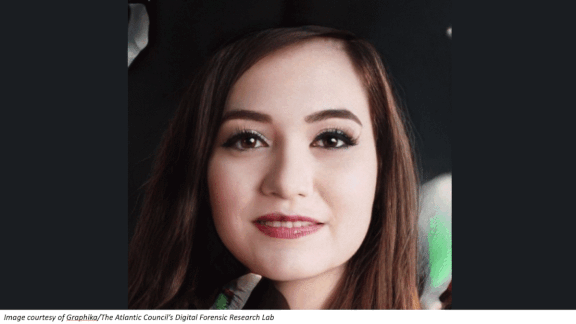



Image summary: 
Close-up of a young woman with long, dark hair and striking makeup, featuring defined eyelashes and a subtle smile. The background is slightly blurred, emphasizing her face.


Retrieved docs:
[Document(metadata={'doc_id': 'https://www.deeplearning.ai/the-batch/a-good-look-for-ai/', 'image_url': 'a-good-look-for-ai/url_https_3A_2F_2Fdl-staging-website_ghost_io_2Fcontent_2Fimages_2F2021_2F08_2FA-Good-Look-for-AI-1_gif_w_3840_q_75.jpg', 'split_id': 0, 'type': 'image', 'relevance_score': 0.9073123}, page_content="A close-up of a woman's face showcasing various makeup effects, including lipstick and eye makeup, applied virtually using augmented reality technology.The image highlights the seamless integration of digital makeup application, emphasizing the natural look and glossy finish of the products."), Document(metadata={'doc_id': 'https://www.deeplearning.ai/the-batch/facebook-vs-deepfakes/', 'image_url': 'facebook-vs-deepfakes/url_https_3A_2F_2Fdl-staging-website_ghost

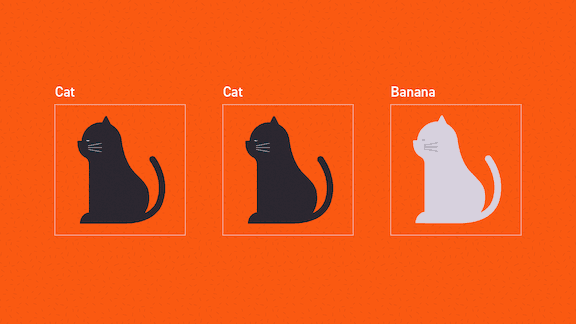



Image summary: 
Image features three stylized cat silhouettes against an orange background. The first two silhouettes are labeled "Cat" and are in black and gray colors, respectively. The third silhouette is labeled "Banana" and is a light gray color, depicting a cat-like shape.


Retrieved docs:
[Document(metadata={'doc_id': 'https://www.deeplearning.ai/the-batch/biased-data-trains-oppressive-ai/', 'image_url': 'biased-data-trains-oppressive-ai/url_https_3A_2F_2Fdl-staging-website_ghost_io_2Fcontent_2Fimages_2F2021_2F07_2FBiased-Data-Trains-Oppresive-AI-1_png_w_3840_q_75.jpg', 'split_id': 0, 'type': 'image', 'relevance_score': 0.9999994}, page_content='Image features three stylized cat silhouettes against an orange background.The first two silhouettes are labeled "Cat," while the third silhouette, which is a different color, is incorrectly labeled "Banana."'), Document(metadata={'doc_id': 'https://www.deeplearning.ai/the-batch/biased-data-trains-oppressive-ai/', 'image_url': 'biased

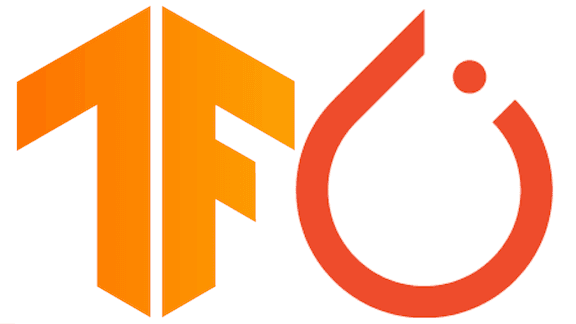



Image summary: 
Image features two prominent logos: the TensorFlow logo, characterized by bold orange geometric shapes, and the PyTorch logo, featuring a stylized red flame symbol. The logos are visually distinct, representing two popular machine learning frameworks.


Retrieved docs:
[Document(metadata={'doc_id': 'https://www.deeplearning.ai/the-batch/clash-of-the-frameworks/', 'image_url': 'clash-of-the-frameworks/url_https_3A_2F_2Fdl-staging-website_ghost_io_2Fcontent_2Fimages_2F2021_2F07_2FClash-of-the-Frameworks-1_png_w_3840_q_75.jpg', 'split_id': 0, 'type': 'image', 'relevance_score': 0.9999995}, page_content='Image features the logos of TensorFlow (TF) and PyTorch (PyG), representing two popular deep learning frameworks.The TensorFlow logo is on the left, characterized by a stylized "TF" in orange, while the PyTorch logo on the right features a red flame with a circular design.'), Document(metadata={'doc_id': 'https://www.deeplearning.ai/the-batch/clash-of-the-frameworks/', 'i

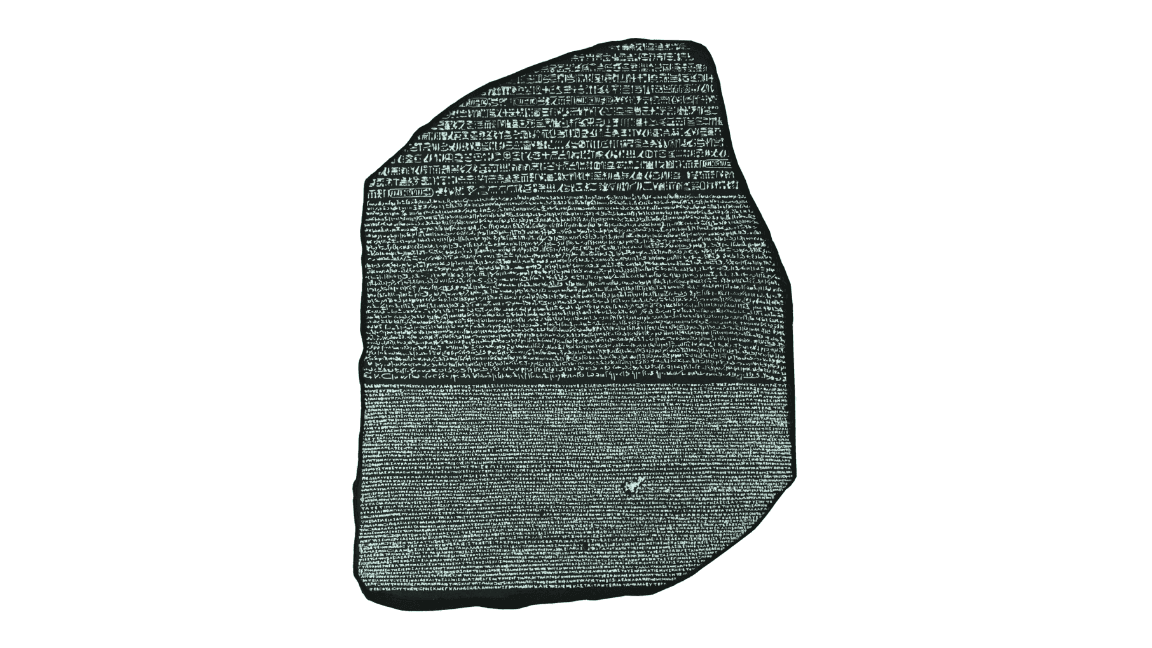



Image summary: 
The image features the Rosetta Stone, a large, flat, rectangular rock inscribed with text in three scripts: Greek, Demotic, and hieroglyphics. The stone is characterized by its rough, uneven edges and dense inscriptions, which are critical for understanding ancient Egyptian writing and language.


Retrieved docs:
[Document(metadata={'doc_id': 'https://www.deeplearning.ai/the-batch/digital-rosetta-stone/', 'image_url': 'digital-rosetta-stone/url_https_3A_2F_2Fdl-staging-website_ghost_io_2Fcontent_2Fimages_2F2022_2F10_2F513ac1af-a7bd-442b-aa21-92944bb6fdf0--1-_png_w_3840_q_75.jpg', 'split_id': 0, 'type': 'image', 'relevance_score': 0.9950563}, page_content='Image Summary: A fragment of an ancient stone tablet featuring inscriptions in multiple ancient scripts, showcasing dense text patterns.This artifact exemplifies the linguistic complexities being addressed by new algorithms developed for deciphering lost languages, as mentioned in recent research by MIT CSAIL and Goo

In [19]:
import PIL
from IPython.display import display
from app.modules.image_processor.utils import generate_img_summaries, encode_image
from app.modules.qa_chain_composer.utils import create_multi_modal_query_from_description

for img_id in img_idx:
    retrieved_img_url = vector_store.get()['metadatas'][img_id]["image_url"]

    image = PIL.Image.open(f"./data/doc_dataset/images_clean/{retrieved_img_url}")
    display(image)
    image_summary = generate_img_summaries(f"./data/doc_dataset/images_clean/{retrieved_img_url}", image_encoder=encode_image)
    print("\n\nImage summary: ")
    print(image_summary)

    query = create_multi_modal_query_from_description(question="Describe relation image content to AI.", image_description=image_summary)
    retrieved_docs = retriever.get_relevant_documents(query)
    print("\n\nRetrieved docs:")
    print(retrieved_docs)

    # Convert retrieved documents to context string
    context = "\n\n".join([doc.page_content for doc in retrieved_docs])

    chain_inputs = {
        "context": context,
        "text_input": "Describe relation image content to AI.",
        "image_description": image_summary
    }
    result = qa_chain.invoke(chain_inputs)
    print("\n\n Result:")
    print(result)

### Image extraction performs pretty well, along with qa. Let's now see for solely text requests

In [20]:
# article_idx = [0, 100, 150, 200]
# np.array(vector_store.get()['metadatas'])[article_idx]

In [30]:

qa_list = [
    "Why AI algorithms are called black-box?",
    "What Is Game Theory?",
    "What are embeddings in machine learning?"
]

In [31]:
for question in qa_list:
    print("\n\nQuestion:")
    print(question)
    query = create_multi_modal_query_from_description(question=question)
    retrieved_docs = retriever.get_relevant_documents(query)
    print("\n\nRetrieved docs:")
    print(retrieved_docs)

    # Convert retrieved documents to context string
    context = "\n\n".join([doc.page_content for doc in retrieved_docs])

    chain_inputs = {
        "context": context,
        "text_input": question,
        "image_description": None
    }
    result = qa_chain.invoke(chain_inputs)
    print("\n\n Result:")
    print(result)



Question:
Why AI algorithms are called black-box?


Retrieved docs:
[Document(metadata={'doc_id': 'https://www.deeplearning.ai/the-batch/building-trustworthy-ai/', 'image_url': '', 'split_id': 8, 'type': 'text', 'relevance_score': 0.99773055}, page_content='Similarly, black-box AI algorithms might gain our trust by undergoing rigorous testing.Boundary conditions.Clearly specifying boundary conditions (where the AI is expected to work) also helps.'), Document(metadata={'doc_id': 'https://www.deeplearning.ai/the-batch/building-trustworthy-ai/', 'image_url': '', 'split_id': 7, 'type': 'text', 'relevance_score': 0.97409195}, page_content='We trust these drugs because they have passed randomized clinical trials and received FDA approval.Similarly, black-box AI algorithms might gain our trust by undergoing rigorous testing.Boundary conditions.'), Document(metadata={'doc_id': 'https://www.deeplearning.ai/the-batch/bias-goes-undercover/', 'image_url': '', 'split_id': 0, 'type': 'text', 'rele

### **Both multimodal and text-only perform well**